As results come in election night, counties vary widely in representation of democrat vs republican margins. Rural counties tend to heavily favor republicans, while counties in urban areas tend to favor democrats, so depending on which counties are being reported first, early result margins might not represent the true, state-wide count. For example, Fulton county Georgia is upwards of 75% democrat, so if Fulton county reports first, it might initially seem like democrats are headed for a state-wide double digit blow out, but in reality, a 75% democrat vote in Fulton county is indicative of a close race state-wide. Our goal is to build such a model, that predicts state-wide results based on election night returns on a county level.

# Data Acquisition

In [1]:
### Import required libraries.
import json
import math
import pandas as pd
import os
import requests
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import zipfile
import re
import boto3
from sklearn import preprocessing
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from datetime import datetime
from IPython.display import HTML,display,Javascript


import warnings
warnings.filterwarnings('ignore')


from urllib.request import urlopen, Request
#display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline


## Loading Dataset
We're building a model to predict state wide results based on county results, and as before, we'll be using Georgia as our test case. We'll gather data from past elections going back to 2014:
1. [2014 United States Senate Election](https://results.enr.clarityelections.com/GA/54042/149045/en/reports.html)
2. [2016 United States Presidential eleciton](https://results.enr.clarityelections.com/GA/63991/184321/en/reports.html)
3. [2018 Georgia Gubernatorial Election](https://results.enr.clarityelections.com/GA/91639/Web02-state.221451)
4. [2020 United States Presidential eleciton](https://results.enr.clarityelections.com/GA/107231/web.264614/#/summary)
5. [2021 United States Senate runoff Election](https://results.enr.clarityelections.com/GA/107556/web.274956/#/summary)
6. [2022 United States Senate Election](https://results.enr.clarityelections.com/GA/115465/web.307039/#/summary)

and to test our model we'll use [2022 United States Senate Runoff Election](https://results.enr.clarityelections.com/GA/116564/web.307039/#/summary)

This data was obtained from the [Georgia secretary of state elections website](https://results.enr.clarityelections.com/GA/). Normally we'd download this data directly in-code, but the xls format provided can't be parsed easily with pandas, so the file was:
1. saved locally
2. opened in excel
3. re-saved as xlsx.

In [2]:

def column_trim(columns):
    #parse and clean column names
    renamed_columns=[]
    pattern = r'[(,)]'
    for column in columns:
        l = re.split(pattern,column[0])
        renamed_columns.append((' '.join((l[-2][0] if len(l)>1 else '',column[1])).strip()))
    return(renamed_columns)
def county_level_election_df_format(county_count_df):
    #format data frame to only include 
    #1. democrat results by county 
    #2. state wide democrat results 
    #3. county name
    #4. registered voter precentage of county
    county_count_df.columns=column_trim(county_count_df.columns)
    df_columns=[i for i in ['R Total Votes', 'D Total Votes','L Total Votes','Registered Voters'] if i in county_count_df.columns]
    county_total_df=county_count_df[df_columns]
    county_percent_df=county_total_df
    party_columns=[i for i in county_percent_df.columns if i not in ['Registered Voters']]
    county_percent_df[party_columns]=county_total_df[party_columns].div(county_total_df[party_columns].sum(axis=1), axis=0)
    county_percent_df['state_dem_vote_pct']=county_percent_df.iloc[-1]['D Total Votes']
    county_percent_df.rename(columns={'Registered Voters':'registered_voters','D Total Votes':'county_dem_vote_pct'}, inplace=True)
    county_percent_df.index = county_percent_df.index.set_names(['county'])
    county_percent_df=county_percent_df.reset_index()[['registered_voters','county','county_dem_vote_pct','state_dem_vote_pct']].iloc[:-1] 
    return(county_percent_df)
ga_14_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2014/detail.xlsx', 'rb'),index_col=0,header=[1, 2], sheet_name='2')
ga_14_county_percent_df=county_level_election_df_format(ga_14_county_count_df)

ga_16_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2016/detail.xlsx', 'rb'),index_col=0,header=[1, 2], sheet_name='2')
ga_16_county_percent_df=county_level_election_df_format(ga_16_county_count_df)

ga_18_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2018/detail.xlsx', 'rb'),index_col=0,header=[1, 2], sheet_name='2')
ga_18_county_percent_df=county_level_election_df_format(ga_18_county_count_df)

ga_20_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2020/detail.xlsx', 'rb'),index_col=0,header=[1, 2], sheet_name='1')
ga_20_county_percent_df=county_level_election_df_format(ga_20_county_count_df)

ga_21_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2021/detail.xlsx', 'rb'),index_col=0,header=[1, 2], sheet_name='2')
ga_21_county_percent_df=county_level_election_df_format(ga_21_county_count_df)

ga_22_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2022/detail.xlsx', 'rb'),index_col=0,header=[1, 2], sheet_name='2')
ga_22_county_percent_df=county_level_election_df_format(ga_22_county_count_df)

ga_22_gov_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2022/detail.xlsx', 'rb'),index_col=0,header=[1, 2], sheet_name='3')
ga_22_gov_county_percent_df=county_level_election_df_format(ga_22_gov_county_count_df)

parsed each election to only include the following columns, and combined our training data into on data frame 

1. democrat results by county 
2. state-wide democrat results 
3. county name
4. registered voter percentage of county

In [3]:

top_counties= ['Fulton',
               'Gwinnett',
               'Cobb',
               'DeKalb',
               'Chatham',
               'Cherokee',
               'Clayton',
               'Henry',
               'Forsyth',
               'Hall',
               'Richmond',
               'Muscogee',
               'Paulding',
               'Bibb']

ga_county_percent_df=pd.concat([ga_22_county_percent_df,
                                ga_21_county_percent_df,
                                ga_20_county_percent_df, 
                                ga_18_county_percent_df,
                                ga_16_county_percent_df,
                                ga_14_county_percent_df]).reset_index(drop=True)




# Exploratory Analysis

Our goal is to predict final state-wide results based on county level results. Let's start by looking at the distribution of the data, then try fitting model to predict state-wide results.

### Display Election Data

Let's display sample of merged election data to get an idea of the distribution.

In [4]:
ga_county_percent_df.loc[ga_county_percent_df['county'].isin(top_counties)]

,registered_voters,county,county_dem_vote_pct,state_dem_vote_pct
10,105277,Bibb,0.612976,0.494450
24,198440,Chatham,0.594296,0.494450
27,191394,Cherokee,0.292458,0.494450
30,178028,Clayton,0.874452,0.494450
32,508145,Cobb,0.567790,0.494450
...,...,...,...,...
863,78875,Hall,0.209591,0.452071
869,120143,Henry,0.494568,0.452071
900,100438,Muscogee,0.584426,0.452071
904,76088,Paulding,0.287578,0.452071


Let's start by plotting the distributions of our dependent variable, the county level democrat results, and independent variable, state-wide democrat vote percentage.

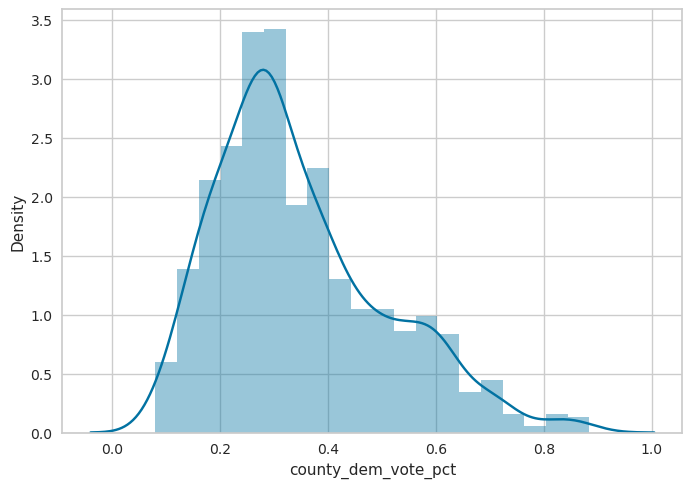

In [6]:
sns.distplot(ga_county_percent_df.county_dem_vote_pct)
plt.show()

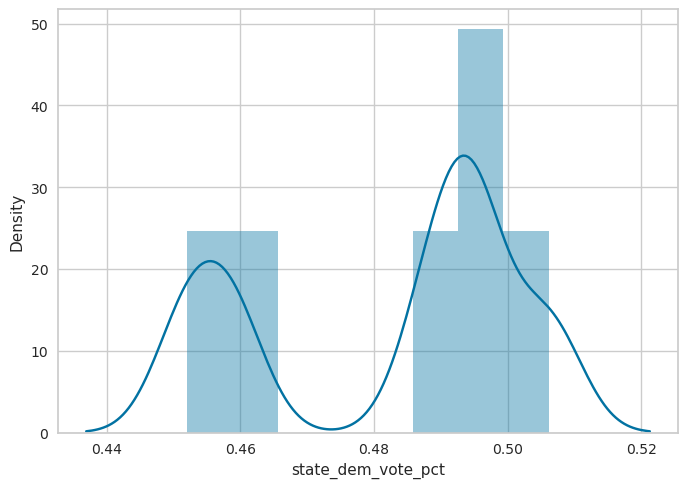

In [7]:
sns.distplot(ga_county_percent_df.state_dem_vote_pct)
plt.show()

In [8]:
#display unique value counts for each variable
pd.DataFrame(ga_county_percent_df.nunique(),columns=["unique values in column"])

,unique values in column
registered_voters,777
county,159
county_dem_vote_pct,954
state_dem_vote_pct,6


We have 100 counties with 6 observations each. That gives us 159∗6=954 observations of county level returns, but we still only have 6 observations for state-wide results. 

### Visualizing Our Data Through Regression

Before we fit a model to predict state-wide results based on county level returns, let's get a baseline understanding of our data by fitting an ordinary linear regression plot 


#### Ordinary Linear Regression

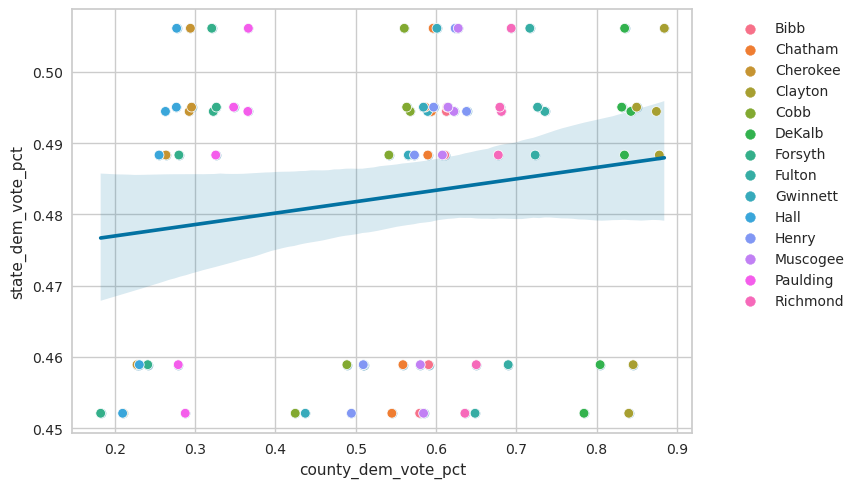

In [9]:
fig, ax = plt.subplots()
lo=sns.regplot(y = "state_dem_vote_pct" , 
           x = "county_dem_vote_pct", 
           data = ga_county_percent_df.loc[ga_county_percent_df['county'].isin(top_counties)],
           scatter_kws={"alpha":0.5},  ax=ax)
ll=sns.scatterplot(y = "state_dem_vote_pct" , 
                   x = "county_dem_vote_pct", 
                   data = ga_county_percent_df.loc[ga_county_percent_df['county'].isin(top_counties)],
                   hue='county',
                   ax=ax)


ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Ordinary linear regression ignores county classification, and most election are close to 50/50, so the prediction made by a simple linear regression isn't too bad, but looking closely at the data, the slope of our regression line is near zero, and we're getting an almost singular fit. No matter which county level return we use in our simple linear regression, we're going to get 48% state-wide result. 

Our data has 159 counties, and each of the 6 election data points are not independent across county lines. For example, if the democrat returns are higher than average in Fulton county, then the democrat returns are probably higher in other counties, in fact, that's what measuring. To look at the impact of county-level returns on state-level results we need to control for the variation between the different counties. We have to treat our counties as random effects, and build a mixed effect model

#### Separate Linear Regression
The difference between separate linear regression fits for each county, and a mixed effect model, is a mixed effect model still builds a single regression model across all 159 counties, with a fixed slope, but a random intercept value for each 0f the 159 counties. Before we build our mixed effect model, let's get an idea of the county random effects.

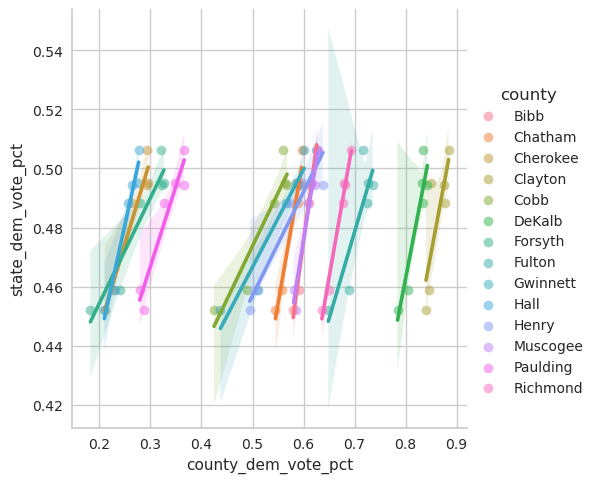

In [12]:

sns.lmplot(y = "state_dem_vote_pct" , 
             x = "county_dem_vote_pct", 
             data = ga_county_percent_df.loc[ga_county_percent_df['county'].isin(top_counties)],
             hue="county",
             scatter_kws={"alpha":0.5})


From the separate linear regression lines, we're looking to fix the slope across all 159 counties, but want the intercepts to vary. Let's see what happens if we build a mixed effects model with:
* y = state_dem_vote_pct 
* x = county_dem_vote_pct
* Group = county

$$
\begin{align*}
state\_dem\_vote\_pct_{i} = \beta*county\_dem\_vote\_pct_{i} + u_{i}*county_{i}  \\ \\
u_{i} \sim N(O, D) \\
\end{align*}
$$

In [13]:
# construct our model, with our county now shown as a group
md = smf.mixedlm("state_dem_vote_pct ~ county_dem_vote_pct", 
                 ga_county_percent_df,
                 groups=ga_county_percent_df["county"])
mdf = md.fit()
print(mdf.summary())


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: state_dem_vote_pct
No. Observations: 954     Method:             REML              
No. Groups:       159     Scale:              0.0004            
Min. group size:  6       Log-Likelihood:     2371.7948         
Max. group size:  6       Converged:          No                
Mean group size:  6.0                                           
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             0.483    0.002 308.199 0.000  0.480  0.486
county_dem_vote_pct  -0.000    0.004  -0.066 0.947 -0.008  0.008
Group Var             0.000                                     



In [14]:
pd.DataFrame({"County":top_counties,
              "intercept":[mdf.random_effects[county] .Group for county in top_counties]})

,County,intercept
0,Fulton,5.718432e-07
1,Gwinnett,3.186557e-07
2,Cobb,2.810877e-07
3,DeKalb,7.555975e-07
4,Chatham,3.672375e-07
5,Cherokee,-1.341566e-07
6,Clayton,8.194038e-07
7,Henry,3.579866e-07
8,Forsyth,-1.106011e-07
9,Hall,-1.533886e-07


unfortunately, our linear mixed model appears to converge to singular fit. The slope is zero, and our random intercept is also near zero. What we're building with our linear mixed model is a fixed slope and random intercept distributed along the y-axis(`state_dem_vote_pct`). What we actually need is a random intercept distributed along the x-axis. 

we're going to
1. reverse our dependent and independent variable 
2. fit our mixed effect model with county as the random effects
3. solve for `state_dem_vote_pct`

$$
\begin{align*}
county\_dem\_vote\_pct_{i} = ( state\_dem\_vote\_pct_{i} - u_{i}*county_{i} )/\beta  \\ \\
u_{i} \sim N(O, D) \\
\end{align*}
$$

# Fitting A Mixed Effect Model

We’re going to be using the R lme4 library through `rpy2` to fit our mixed effects model instead of python’s `statsmodels`, not because we enjoy the punishment, but because we’re weighting the regions fit by registered voter for each county. We don’t want, for example, Webster county, which has roughly 1,000 registered voters to have the same weight as Fulton county, which has around 750k registered voters. Python’s `statsmodels` does not allow for weighting in mixed effects model. 


In [15]:
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
import rpy2.ipython.html
base = importr('base')
lme = importr('lme4')
arm = importr('arm')
stats = importr('stats')


rpy2.ipython.html.init_printing()
utils = importr('utils')


As stated above, we're building our model initially to predict county level returns from state-side vote percentage
* y = `county_dem_vote_pct`
* x = `state_dem_vote_pct`
* Group = `county`

In [16]:
def pandasDF2R(df):
    with robjects.conversion.localconverter(rpy2.robjects.default_converter + pandas2ri.converter):
        if hasattr(robjects.conversion,'py2ri'):
            ret = robjects.conversion.py2ri(df)
        else:
            ret = robjects.conversion.py2rpy(df)
    return ret
#build model
MLexamp = lme.lmer(formula = 'county_dem_vote_pct ~ state_dem_vote_pct  + (1|county)',
                   weights = robjects.FloatVector(ga_county_percent_df['registered_voters']), 
                   data=pandasDF2R(ga_county_percent_df))


In [17]:
MLexamp_summary=base.summary(MLexamp)

MLexamp_summary_dict=dict(zip(MLexamp_summary.names, list(MLexamp_summary)))


dash = '-' * 80
double_dash = '='* 80
print('{:<15}{:<50s}'.format("","Mixed Linear Model Regression Results"))
print(double_dash)
print('{:<25}{:<70s}'.format("Method:",MLexamp_summary_dict['methTitle'][0]))
print('{:<25}{:<70n}'.format("No. Groups",MLexamp_summary_dict['ngrps'][0]))
print(dash)
print('{:<25}{:<15s}{:<15s}{:<15s}'.format("","Coef","Std.Err.","z"))
print(dash)
print('{:<25}{:<15n}{:<15n}{:<15n}'.format("Intercept",MLexamp_summary_dict['coefficients'][0],MLexamp_summary_dict['coefficients'][2],MLexamp_summary_dict['coefficients'][4]))
print('{:<25}{:<15n}{:<15n}{:<15n}'.format("state_dem_vote_pct",MLexamp_summary_dict['coefficients'][1],MLexamp_summary_dict['coefficients'][3],MLexamp_summary_dict['coefficients'][5] ))




               Mixed Linear Model Regression Results             
Method:                  Linear mixed model fit by REML                                        
No. Groups               159                                                                   
--------------------------------------------------------------------------------
                         Coef           Std.Err.       z              
--------------------------------------------------------------------------------
Intercept                -0.176067      2.53148        -0.0695511     
state_dem_vote_pct       1.08323        0.0390714      27.7244        


### Test Our Fit

Let's get the root mean squared error of the data we used to build our regression model and calculate the error for our test data set, the 2022 runoff Senate election

In [18]:


ga_county_percent_residuals_df= ga_county_percent_df.copy()
#get slope and intecept for each county
groups_df=pandas2ri.rpy2py_dataframe(stats.coef(MLexamp)[0])
groups_df=groups_df.rename(columns={"(Intercept)": "intercept", "state_dem_vote_pct": "slope"})
#ger residuals for each county from the R dataframe
ga_county_percent_residuals_df['residuals']=pandas2ri.rpy2py_floatvector(stats.residuals(MLexamp))
ga_county_percent_goups_df=groups_df.join(ga_county_percent_residuals_df.set_index('county'))
ga_county_percent_goups_df=ga_county_percent_goups_df.reset_index().rename(columns={'index': 'county'})
#calculate the predicted y value(county_dem_vote_pct) for each county
y_predict = ga_county_percent_goups_df.slope*ga_county_percent_goups_df.state_dem_vote_pct+ga_county_percent_goups_df.intercept
y = ga_county_percent_goups_df['state_dem_vote_pct']
#get Error for the data we used to train the model
RMSE_Train = math.sqrt(((y-y_predict)**2).values.mean())


ga_22_county_percent_goups_df=groups_df.join(ga_22_county_percent_df.set_index('county'))
ga_22_county_percent_goups_df=ga_22_county_percent_goups_df.reset_index().rename(columns={'index': 'county'})
#predict county_dem_vote_pct for out test data of the 2022 runoff election 
y_predict = ga_22_county_percent_goups_df.slope*ga_22_county_percent_goups_df.state_dem_vote_pct+ga_22_county_percent_goups_df.intercept
y = ga_22_county_percent_goups_df['state_dem_vote_pct']
#calculate error for 2022 runoff election, our test data
RMSE_Test = math.sqrt(((y-y_predict)**2).values.mean())


results = pd.DataFrame()
results["Method"] = ["Mixed"]
results["RMSE of training"] = RMSE_Train
results["RMSE of test data"] = RMSE_Test
results

,Method,RMSE of training,RMSE of test data
0,Mixed,0.207855,0.207199



let's take a look at the residuals graph for our fit

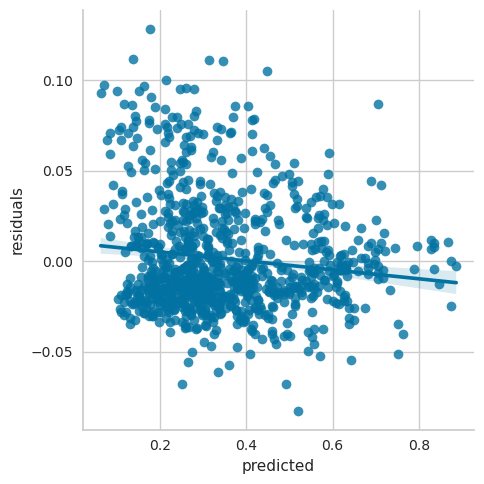

In [21]:
y_predict = ga_county_percent_goups_df.slope*ga_county_percent_goups_df.state_dem_vote_pct+ga_county_percent_goups_df.intercept


# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = ga_county_percent_goups_df.reset_index()['residuals']
performance["state_dem_vote_pct"] = ga_county_percent_goups_df.reset_index()['state_dem_vote_pct']
performance["predicted"] = y_predict.reset_index()[0]
sns.lmplot(x = "predicted", 
           y = "residuals",
           data = performance)

not great, but not terrible. This fit will work

## Applying The Model To Real Time Data

The goal of our model was to recreate the New York Times election needle. As results come in throughout election night, we attempt to forecast the final state-wide results, based on county level returns. We're going to apply our model to real-time capture of the 2022 senate runoff election, and compare our projection to results as they were reported on election night.  


### Parse Election
load AP election capture data from the Georgia Senate Election. The results is a dictionary indexed by capture time of election results throughout election night.

In [22]:
def download(url: str, dest_folder: str):
    filename = url.split('/')[-1].replace(" ", "_")
    file_path = os.path.join(dest_folder, filename)
    
    if not os.path.exists(file_path):
        os.makedirs(dest_folder, exist_ok=True)
        r = requests.get(url, stream=True)
        if r.ok:
            print("saving to", os.path.abspath(file_path))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
        else:  
            print("Download failed: status code ",r.status_code)
            print(r.text)
        
        
# Download fips data, and load it into data frame
download("https://raw.githubusercontent.com/ChuckConnell/articles/master/fips2county.tsv", dest_folder="./data")
fips_df = pd.read_csv('./data/fips2county.tsv', sep='\t', header='infer', dtype=str, encoding='latin-1')
fips_df=fips_df.set_index('CountyFIPS')
def build_ap_eleciton_data(eleciton_data):
    county_fipps=set(eleciton_data.keys())-set(['metadata','summary'])
    election_data_counties=[eleciton_data[code] for code in county_fipps ]
    df=pd.json_normalize(election_data_counties,'candidates',['fipsCode',
                                                              'precinctsReporting',
                                                              'precinctsTotal',
                                                              'eevp',
                                                              ['parameters','vote','expected','actual'],
                                                              ['parameters','vote','total'],
                                                              ['parameters','vote','registered']])


    df['candidateID']=df['candidateID'].apply(lambda x: eleciton_data['metadata']['candidates'][x]['first']+\
                                                        eleciton_data['metadata']['candidates'][x]['last'])
    df['county']=fips_df.loc[df['fipsCode']].reset_index()['CountyName']
    df=groups_df.join(df.set_index('county')).reset_index()
    df = df.set_index(['fipsCode','candidateID'])
    return df


def ap_election_from_file(election_dir):
    files = os.listdir(election_dir)
    files = sorted([(f.split('_')[0],f) for f in files if os.path.isfile(election_dir+'/'+f)]) 
    #dictionary indexed by capture time, holds dataframe of county results 
    election_timeseries={}
    #loop through each election capture 
    for epoch, file in files:
        with open(election_dir+file) as f:
            eleciton_data = json.loads(f.read())
        election_timeseries[epoch]=build_ap_eleciton_data(eleciton_data)
    return election_timeseries

def ap_election_from_S3(bucket_name, prefix ):
    s3 = boto3.client('s3')
    resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    files = [ obj['Key']   for obj in resp['Contents']]
    files = sorted(map(lambda file: (file.split('/')[-1].split('_')[0],file), files))
    election_timeseries={}
    for epoch, file in files:
        data=s3.get_object(Bucket=bucket_name, Key=file )
        contents = data['Body'].read()
        eleciton_data = json.loads(contents.decode("utf-8"))
        election_timeseries[epoch]=build_ap_eleciton_data(eleciton_data)
    return election_timeseries


runoff_timeseries=ap_election_from_file('./data/2022/GA/ussenate/runoff/')

As we cycle through the 2022 runoff election results, we're going to have two catagories of data

* reporting counties
* counties not yet reporting

for reporting counties, we calculate the democrat margin as would be calculated on election night, and we use the reporting counties to project results for the none-reporting counties. 

our model currently predicts county-level returns based on state-wide results


$$
\begin{align*}
state\_dem\_vote\_pct_{i} = \beta*county\_dem\_vote\_pct_{i} + u_{i}*county_{i}  \\ \\
u_{i} \sim N(O, D) \\
\end{align*}
$$

we solve for `county_dem_vote_pct`

$$
\begin{align*}
county\_dem\_vote\_pct_{i} = ( state\_dem\_vote\_pct_{i} - u_{i}*county_{i} )/\beta  \\ \\
u_{i} \sim N(O, D) \\
\end{align*}
$$





In [23]:
runoff_epoch_keys=list(runoff_timeseries.keys())
final_result=runoff_timeseries[runoff_epoch_keys[-1]]
true_result=final_result.xs('RaphaelWarnock', level='candidateID')['voteCount'].sum()/final_result['voteCount'].sum()
error=0
projected_dem_precent=[]
reporting_dem_precent=[]
dem_precent_epoch=[]
final_result_dem_precent=(final_result.xs('RaphaelWarnock', level='candidateID')['parameters.vote.total']*final_result.xs('RaphaelWarnock', level='candidateID')['votePct']/100).sum()/final_result.xs('RaphaelWarnock', level='candidateID')['parameters.vote.total'].sum()
for epoch in runoff_epoch_keys:
    df=runoff_timeseries[epoch]
    reporting_indexes=df[df['eevp']>0].index
    none_reporting_indexes=df[df['eevp']==0].index
    if len(reporting_indexes)>0 :
        dem_reporting_df=df.loc[reporting_indexes].xs('RaphaelWarnock', level='candidateID')
        reporting_dem_vote_total_df=dem_reporting_df['votePct']*dem_reporting_df['parameters.vote.total']/100
        #calculate precent reporting so far
        total_precent_reporting=dem_reporting_df['parameters.vote.total'].sum()/(dem_reporting_df['parameters.vote.expected.actual'].sum())
        expected_state_vote_df=(dem_reporting_df['votePct']/100.-dem_reporting_df['intercept'])/dem_reporting_df['slope']
        expected_state_vote=(dem_reporting_df['parameters.vote.registered']*expected_state_vote_df).sum()/dem_reporting_df['parameters.vote.registered'].sum()



        if(len(none_reporting_indexes)>0):
            dem_none_reporting_df=df.loc[none_reporting_indexes].xs('RaphaelWarnock', level='candidateID')
            none_reporting_predicted_df=dem_none_reporting_df['slope']*expected_state_vote+dem_none_reporting_df['intercept']
            #use precent reporting so far * non reporting expected votes* projected precent democrat 
            none_reporting_dem_vote_total_df=total_precent_reporting*dem_none_reporting_df['parameters.vote.expected.actual']*none_reporting_predicted_df
            sum_dem_vote=none_reporting_dem_vote_total_df.sum()+reporting_dem_vote_total_df.sum()
            sum_dem_vote_expected=((total_precent_reporting*df['parameters.vote.expected.actual']/2).sum())
            projected_dem_precent.append(sum_dem_vote/sum_dem_vote_expected)
        else:
             projected_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        reporting_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        dem_precent_epoch.append(epoch)


Let's compare our adjusted projection of state-wide returns to results as they were reported

* Error of our model = projected results-true results
* baseline error as reported on election night = reported results-true results

In [24]:
def RMSD(dfp,dfx):
    return(((dfp - dfx) ** 2).mean() ** .5)
error = RMSD(pd.DataFrame(reporting_dem_precent),pd.DataFrame([final_result_dem_precent]*len(reporting_dem_precent)))[0]
print(f'Cumulative baseline error of Raphael Warnock\'s margins in the runoff election {error=}')
error = RMSD(pd.DataFrame(projected_dem_precent),pd.DataFrame([final_result_dem_precent]*len(projected_dem_precent)))[0]
print(f'Cumulative model projected error of Raphael Warnock\'s margins in the runoff election {error=}')



Cumulative baseline error of Raphael Warnock's margins in the runoff election error=0.038462887926662415
Cumulative model projected error of Raphael Warnock's margins in the runoff election error=0.023219842501452988


Our model was just shy of a 40% improvement in predicting state-wide results based on county level returns

<AxesSubplot:xlabel='time', ylabel='precent'>

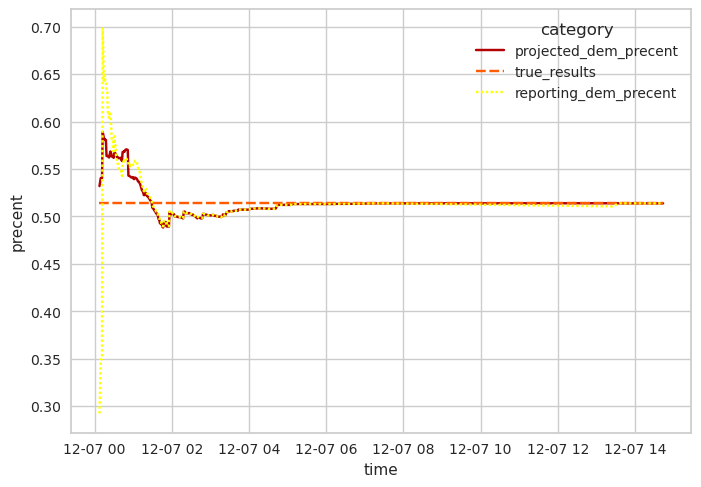

In [25]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['true_results'] = [final_result_dem_precent]*len(projected_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]

# Plot the responses for different events and regions

sns.lineplot(x="time", 
             y="precent",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],var_name='category', value_name='precent'))


# Conclusion

Our goal was to build a model that simulates the New York Times election needle that projects the likely, state-wide final results based on reporting counties. After exploratory analysis, we concluded that mixed effects model was most appropriate to capture random effects between the counties. Above is a time series comparison of our projected Democrat precent of the vote vs. the Democrat results as they were reported on election night. Our projected state-wide results were better than reported results for most of the night, especially early in early reporting, and our projected democrat margin converges with actual results  